![Lights!Camera!Action](Movie_photo.jpg)

---
# BOX Office Movies Analysis
---

## Overview
This project analyzes data from multiple sources listed in the [zipped file](zippedData).


## Business Problem
Your company now sees all the big companies creating original video content and they want to get in on the fun. They have decided to create a new movie studio, but they don’t know anything about creating movies. You are charged with exploring what types of films are currently doing the best at the box office. You must then translate those findings into actionable insights that the head of your company's new movie studio can use to help decide what type of films to create.

---
## Data Understanding
---

The data that is being used has been sourced from different platforms and contains information such as:
- Movie titles
- Movie Genres
- Runtime (Length of the movie)
- Production costs
- Gross income made
- Ratings

With this data we can make conclusions regarding what types of films to create based on consumer preference(rating), production costs and the income made from production in order to answer the business problem. 

### Loading the data into dataframes

In [1]:
#importing necesarry libraries
import pandas as pd
import numpy as np 
import sqlite3

In [2]:
# Specify the file path
file_path = "zippedData/tn.movie_budgets.csv.gz"

# Load the data into a DataFrame
movie_budgets = pd.read_csv(file_path, compression='gzip')

movie_budgets.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [3]:
movie_budgets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


#### Movies ERD

![movies erd](movie_data_erd.jpeg)

In [4]:
#load the movie_basics data into a dataframe
#unzip the file
import zipfile

with zipfile.ZipFile('zippedData/im.db.zip', 'r') as zip_ref:
  # Extract all files (assuming the database file is the only one)
  zip_ref.extractall()

In [5]:
# Connect to the SQLite database
with sqlite3.connect('im.db') as conn:
    #write a query to select the necessary columns
    q ="""SELECT
    mb.primary_title,
    mb.genres,
    p.primary_name
    FROM movie_basics AS mb
    JOIN directors AS d
        ON mb.movie_id = d.movie_id
    JOIN persons AS p
        ON d.person_id = p.person_id
    GROUP BY mb.primary_title
    HAVING primary_profession LIKE '%director%';"""
    # Load the tables into a DataFrame
    movie_basics = pd.read_sql(q, conn)

# Display the first few rows of the DataFrame
movie_basics.head()

,primary_title,genres,primary_name
0,!Women Art Revolution,Documentary,Lynn Hershman-Leeson
1,#1 Serial Killer,Horror,Stanley Yung
2,#5,"Biography,Comedy,Fantasy",Ricky Bardy
3,#50Fathers,Comedy,Joddy Eric Matthews
4,#66,Action,Asun Mawardi


In [6]:
#delete the 'im.db' file, it is too large and only needed for one use. 
import os
file_path = "im.db"

try:
    os.remove(file_path)
    print("File deleted successfully!")
except OSError as e:
    print(f"Error deleting file: {e}")

Error deleting file: [WinError 32] The process cannot access the file because it is being used by another process: 'im.db'


---
## Data Preparation
---

### Data Cleaning

#### Tmbd_movies cleaning
This table contans the numbers needed to perform calculations. I will rename the **movie** column to **movie_title** for ease of use. I will also convert the  useful money columns i.e **production_budget** and **worldwide_gross** into float values and make them easier to use when performing computations.As for the **release_date** column I will split it to maintain the month value and discard the original column. Lastly, I will convert the **worldwide_gross** column into a format that is eay to read. 


In [7]:
#rename the movie column
movie_budgets = movie_budgets.rename(columns={'movie':'movie_title'})

#convert the release_date column to release_month
movie_budgets['release_month'] = movie_budgets['release_date'].str[:3].str.strip()

#delete unnecessary columns
movie_budgets = movie_budgets.drop(['id', 'release_date', 'domestic_gross'], axis=1)

In [8]:
#convert the production_budget and worldwide_gross columns to float 
movie_budgets['production_budget'] = movie_budgets['production_budget'].str.replace('$', '').str.replace(',', '').astype(float)
movie_budgets['worldwide_gross'] = movie_budgets['worldwide_gross'].str.replace('$', '').str.replace(',', '').astype(float)

In [9]:
#display the world_gross column as an easier to read number
pd.set_option('display.float_format', '{:.2f}'.format)

In [10]:
#remove all columns where the worldwide_gross is 0
movie_budgets = movie_budgets[movie_budgets['worldwide_gross'] != 0]

In [11]:
movie_budgets.duplicated().sum()

0

#### Movie_basics Cleaning
Drop all rows with null values in the **genre** column. Rename the remaining two columns from **primary_title** to **movie_title** and **primary_name** to **director**

In [12]:
#drop all rows with NaN values
movie_basics = movie_basics.dropna()

In [13]:
#rename the columns 
movie_basics = movie_basics.rename(columns={'primary_title':'movie_title', 'primary_name':'director_name'})

In [14]:
movie_basics.duplicated().sum()

0

## Merging Dataframes

In [15]:
#merge the movie_budgets and movie_basics dataframes
movies_data = pd.merge(movie_budgets,
                      movie_basics,
                      on=['movie_title'],
                      how='inner')

In [16]:
movies_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1927 entries, 0 to 1926
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   movie_title        1927 non-null   object 
 1   production_budget  1927 non-null   float64
 2   worldwide_gross    1927 non-null   float64
 3   release_month      1927 non-null   object 
 4   genres             1927 non-null   object 
 5   director_name      1927 non-null   object 
dtypes: float64(2), object(4)
memory usage: 90.5+ KB


## Feature Engineering
Generate a new feature called ROI- Return on investments that measures the profitability of the movie.
This will show how each film profited based on the **production_budget** and **worlwide_gross**. 
I will also reorder the columns.

In [17]:
#calculate the ROI column
movies_data['ROI'] = movies_data['worldwide_gross'] - movies_data['production_budget']

In [18]:
#reorder the columns for easier reading
movies_data = movies_data[['movie_title', 'release_month', 'production_budget',
                            'worldwide_gross', 'ROI', 'genres', 'director_name']]

In [19]:
movies_data.head()

,movie_title,release_month,production_budget,worldwide_gross,ROI,genres,director_name
0,Avatar,Dec,425000000.00,2776345279.00,2351345279.00,Horror,Atsushi Wada
1,Pirates of the Caribbean: On Stranger Tides,May,410600000.00,1045663875.00,635063875.00,"Action,Adventure,Fantasy",Rob Marshall
2,Dark Phoenix,Jun,350000000.00,149762350.00,-200237650.00,"Action,Adventure,Sci-Fi",Simon Kinberg
3,Avengers: Age of Ultron,May,330600000.00,1403013963.00,1072413963.00,"Action,Adventure,Sci-Fi",Joss Whedon
4,Avengers: Infinity War,Apr,300000000.00,2048134200.00,1748134200.00,"Action,Adventure,Sci-Fi",Anthony Russo


In [20]:
#save the cleaned dataframe into csv files
movies_data.to_csv('cleaned_data/movies_data.csv', index=False)

---
## Analysis
---

### Box Office Perfomance

In this case we want to find out which movie genres are doing the best in Box Offices.
We will first group the data into **ROI** and **Genres** and create a new dataframe where we will further find the aggregates of the **ROI** interms of *count*, *mean* and *median*. I will thereafter use these measures of frequency and central tendancy to find the highest profiting genres(the top 10 to be exact). 


From the data, the highest profiting genres seem to be **Action** and **Adventure** as the most profitable genres appearing in different combinations. 
The most profitable genre combinations are:
1. Action,Adventure,Animation
2. Adventure,Drama,Fantasy
3. Action, Adventure, Sci-Fi

I ignored the first value suggested by the data in the means beacuse I consider it an outlier and could skew the expected results and I chose 
 **Drama**, **Comedy** and  **Sci-Fi** also seem to be highly profitable in different combinations. The **Documentary** genre was ignored because it only appeared in freqency rather than mean and median ROI. 


In [21]:
#import libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [22]:
# Group the data by genre and calculate the mean ROI
genre_roi = movies_data[['genres', 'ROI']].groupby('genres').agg(['count', 'mean', 'median'])

In [23]:
#grouping by mean and ROI
genre_roi.sort_values(by=('ROI','count'),ascending=False).head(11)

ROI                          
                           count         mean       median
genres                                                    
Drama                        161  26100081.86   4152584.00
Documentary                   80  38019683.12   3657215.00
Comedy                        62  36365263.87  14067620.00
Drama,Romance                 56  35333689.96  12624836.50
Comedy,Drama,Romance          53  25724635.98   4416951.00
Adventure,Animation,Comedy    53 262811628.42 151091610.00
Comedy,Drama                  51  30998083.96  12141617.00
Action,Adventure,Sci-Fi       51 483139106.27 369076069.00
Action,Crime,Drama            40  33897239.35  26192531.00
Comedy,Romance                37  59860290.03  31623819.00
Action,Adventure,Fantasy      36 229761302.75 136332777.50

In [24]:
#groupig by count and ROI
genre_roi.sort_values(by=('ROI','mean'),ascending=False).head(11)

ROI                            
                           count          mean        median
genres                                                      
Adventure,Drama,Sport          1 1122469910.00 1122469910.00
Comedy,Mystery                 1  506464305.00  506464305.00
Action,Adventure,Sci-Fi       51  483139106.27  369076069.00
Adventure,Fantasy              3  469544026.33  695577621.00
Documentary,Thriller           1  354683805.00  354683805.00
Adventure,Drama,Sci-Fi         3  343699429.67  501379375.00
Adventure,Drama,Fantasy        4  334192689.25  338601398.50
Action,Adventure,Animation    17  322257606.47  377599142.00
Crime,Drama,Family             1  321116343.00  321116343.00
Action,Mystery,Sci-Fi          1  314319861.00  314319861.00
Animation                      4  314169157.75  225739564.00

In [25]:
#grouping by median and ROI
genre_roi.sort_values(by=('ROI','median'),ascending=False).head(11)

ROI                            
                           count          mean        median
genres                                                      
Adventure,Drama,Sport          1 1122469910.00 1122469910.00
Adventure,Fantasy              3  469544026.33  695577621.00
Comedy,Mystery                 1  506464305.00  506464305.00
Adventure,Drama,Sci-Fi         3  343699429.67  501379375.00
Action,Adventure,Animation    17  322257606.47  377599142.00
Action,Adventure,Sci-Fi       51  483139106.27  369076069.00
Documentary,Thriller           1  354683805.00  354683805.00
Adventure,Drama,Fantasy        4  334192689.25  338601398.50
Crime,Drama,Family             1  321116343.00  321116343.00
Action,Mystery,Sci-Fi          1  314319861.00  314319861.00
Comedy,Romance,Sci-Fi          1  309105123.00  309105123.00

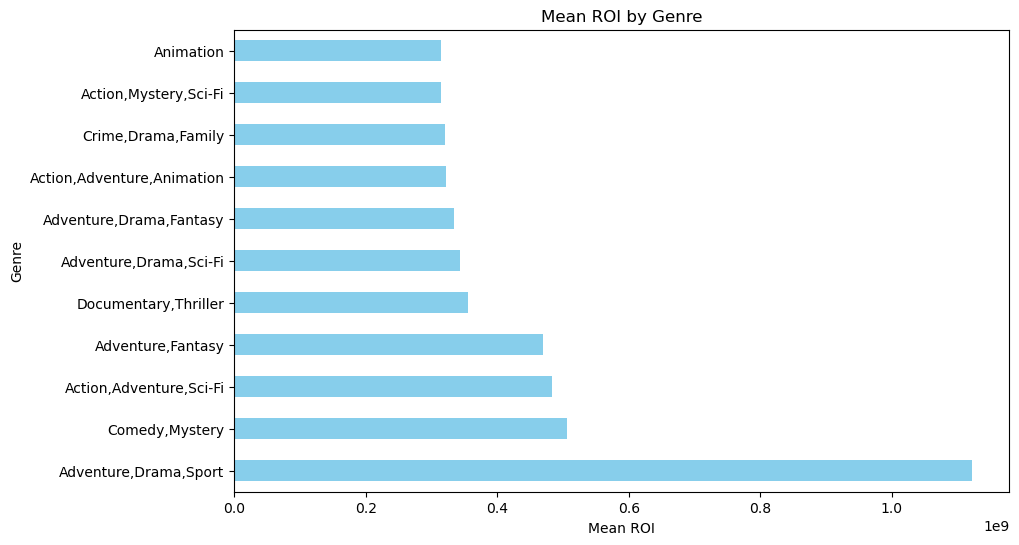

In [26]:
#plot a graph of the mean ROI by genre
fig, ax = plt.subplots(figsize=(6, 6))
mean_genre_roi = genre_roi.sort_values(by=('ROI','mean'),ascending=False).head(11)

ax = mean_genre_roi['ROI']['mean'].plot(kind='barh', figsize=(10, 6), color='skyblue')

ax.set_title('Mean ROI by Genre')
ax.set_xlabel('Mean ROI')
ax.set_ylabel('Genre')
plt.show();

### Release month against ROI

In [27]:
#checking for correlation between worldwide gross and production budget using numpy
# Calculate the correlation between worldwide gross and production budget
correlation = np.corrcoef(cost_info['worldwide_gross'], cost_info['production_budget'])[0, 1]
print(f"The correlation between worldwide gross and production budget is {correlation.round(2)}")


NameError: name 'cost_info' is not defined

In [ ]:
#Simple linear model to show the relationship between worldwide gross and production budget
# Import the linear model function from sklearn
from sklearn.linear_model import LinearRegression

# Create the linear regression model
model = LinearRegression()

# Fit the model to the data
model.fit(cost_info[['production_budget']], cost_info['worldwide_gross'])

# Get the slope and intercept of the line
slope = model.coef_[0]
intercept = model.intercept_

# Print the slope and intercept
print(f"The slope of the line is {slope.round(2)}")
print(f"The intercept of the line is {intercept.round(2)}")


The slope of the line is 3.2
The intercept of the line is -7678293.09


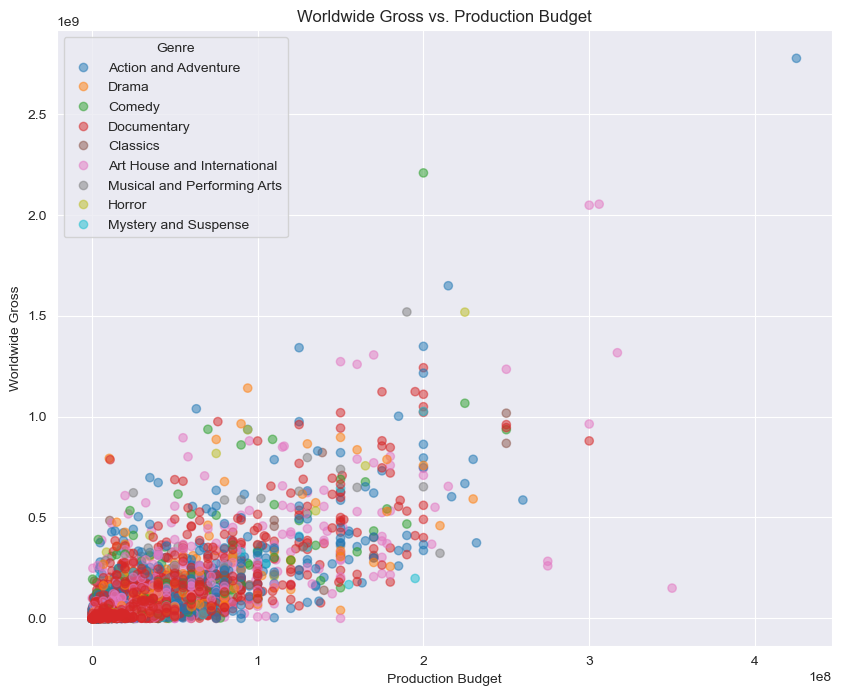

In [ ]:
#graph showing distribution of worldwide gross for different genres using box plot
import seaborn as sns
sns.set_style('darkgrid')

# Create the scatter plot
fig, ax = plt.subplots(figsize=(10, 8))
scatter = ax.scatter(cost_info['production_budget'], cost_info['worldwide_gross'], 
                     c=cost_info['genre1'].astype('category').cat.codes,cmap='tab10', alpha=0.5)

# Get unique genres and their corresponding labels
unique_genres = cost_info['genre1'].unique()
genre_labels = [str(x) for x in unique_genres]  # Convert genres to strings

# Create a legend using scatter plot elements and custom labels
plt.legend(scatter.legend_elements()[0], genre_labels, title='Genre', loc='upper left')  

# Add labels and title
ax.set_title('Worldwide Gross vs. Production Budget')
ax.set_xlabel('Production Budget')
ax.set_ylabel('Worldwide Gross')

plt.show()

#### Results Interpretation

The production budget and worldwide gross seem to have a typically linear relationship with a high positive correlation of `0.75`. This would suggest that a ` higher production budget equates to a high world wide gross`. 
From the graph above, genres such as 'Documentary' and 'Art House and International' seem to have higher budgets with lower returns whereas genres such as 'Comedy' and 'Action and Adventure' seem to have relatively lower production budgets and a higher return.

#### Time Base Analysis

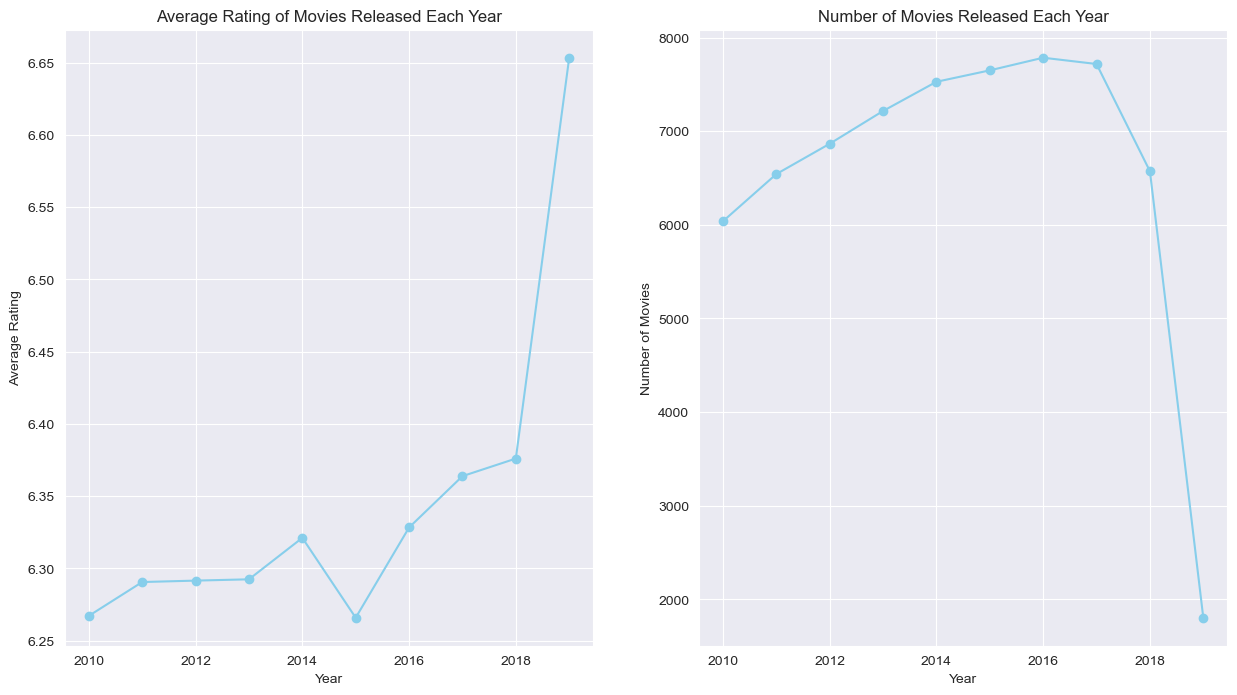

In [ ]:
#line graph showing the average rating of movies released each year
# Group the data by start year and calculate the mean rating
yearly_ratings = movie_data.groupby('start_year')['averagerating'].mean()
yearly_counts = movie_data['start_year'].value_counts().sort_index()

# Create a line plot
fig, axes = plt.subplots(1,2,figsize=(15,8))
axes[0].plot(yearly_ratings.index, yearly_ratings.values, marker='o', color='skyblue')
axes[1].plot(yearly_counts.index, yearly_counts.values, marker='o', color='skyblue')

# Add labels and title
axes[0].set_title('Average Rating of Movies Released Each Year')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Average Rating')

axes[1].set_title('Number of Movies Released Each Year')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Number of Movies')
plt.show();

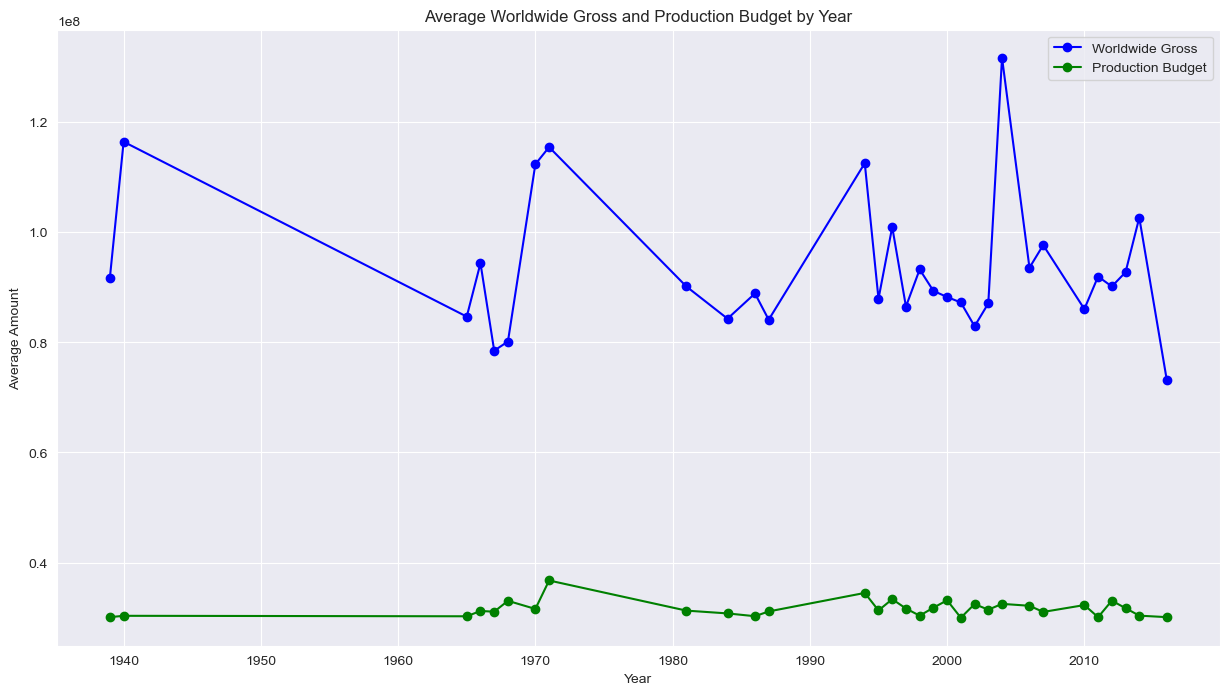

In [ ]:
#line graph showing the trend of average worldwide gross and production budget over the years
# Group the data by start year and calculate the mean worldwide gross and production budget
yearly_gross = cost_info.groupby('theater_date')['worldwide_gross'].mean()
yearly_budget = cost_info.groupby('theater_date')['production_budget'].mean()

# Create a line plot
fig, axes = plt.subplots(figsize=(15,8))
axes.plot(yearly_gross.index, yearly_gross.values, marker='o', color='blue')
axes.plot(yearly_budget.index, yearly_budget.values, marker='o', color='green')

# Add labels and title
axes.set_title('Average Worldwide Gross and Production Budget by Year')
axes.set_xlabel('Year')
axes.set_ylabel('Average Amount')
axes.legend(['Worldwide Gross', 'Production Budget'])
plt.show();

In [ ]:
movie_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65720 entries, 0 to 65719
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   movie_id         65720 non-null  object 
 1   primary_title    65720 non-null  object 
 2   original_title   65720 non-null  object 
 3   start_year       65720 non-null  int64  
 4   runtime_minutes  65720 non-null  float64
 5   genre1           65720 non-null  object 
 6   averagerating    65720 non-null  float64
 7   numvotes         65720 non-null  int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 4.0+ MB


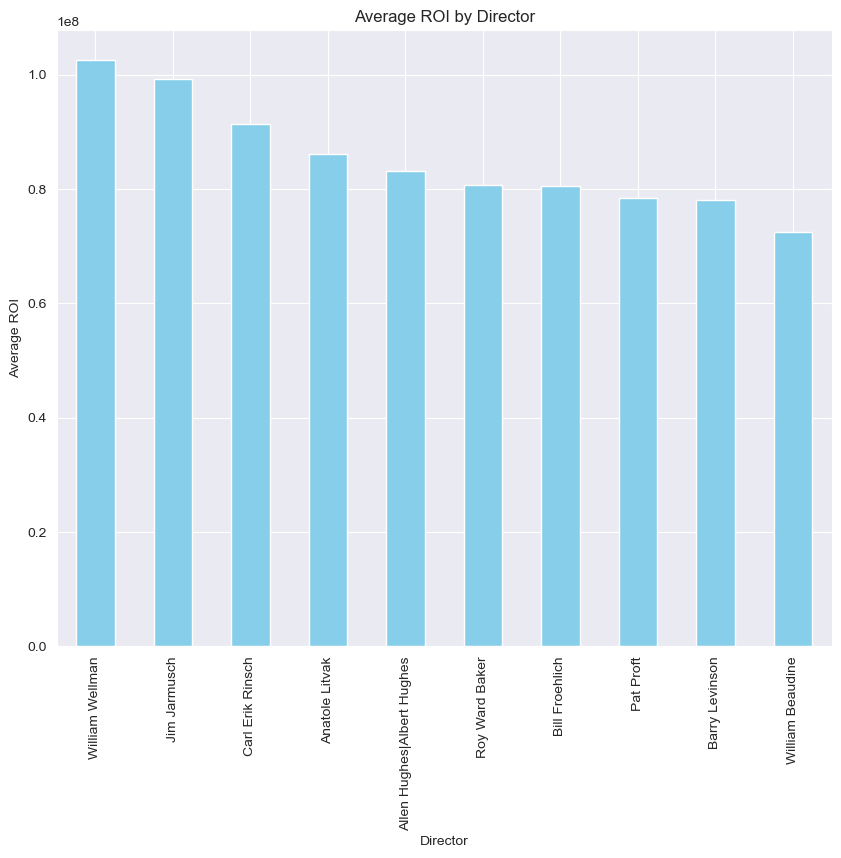

In [ ]:
profitable_directors = cost_info.groupby('director')['ROI'].mean().sort_values(ascending=False).head(10)

# Plot the data
fig, ax = plt.subplots(figsize=(10, 8))
#create a horizontal bar graph



ax = profitable_directors.plot(kind='bar', color='skyblue')
ax.set_title('Average ROI(in Billions) by Director')
ax.set_ylabel('Average ROI')
ax.set_xlabel('Director')
plt.show;

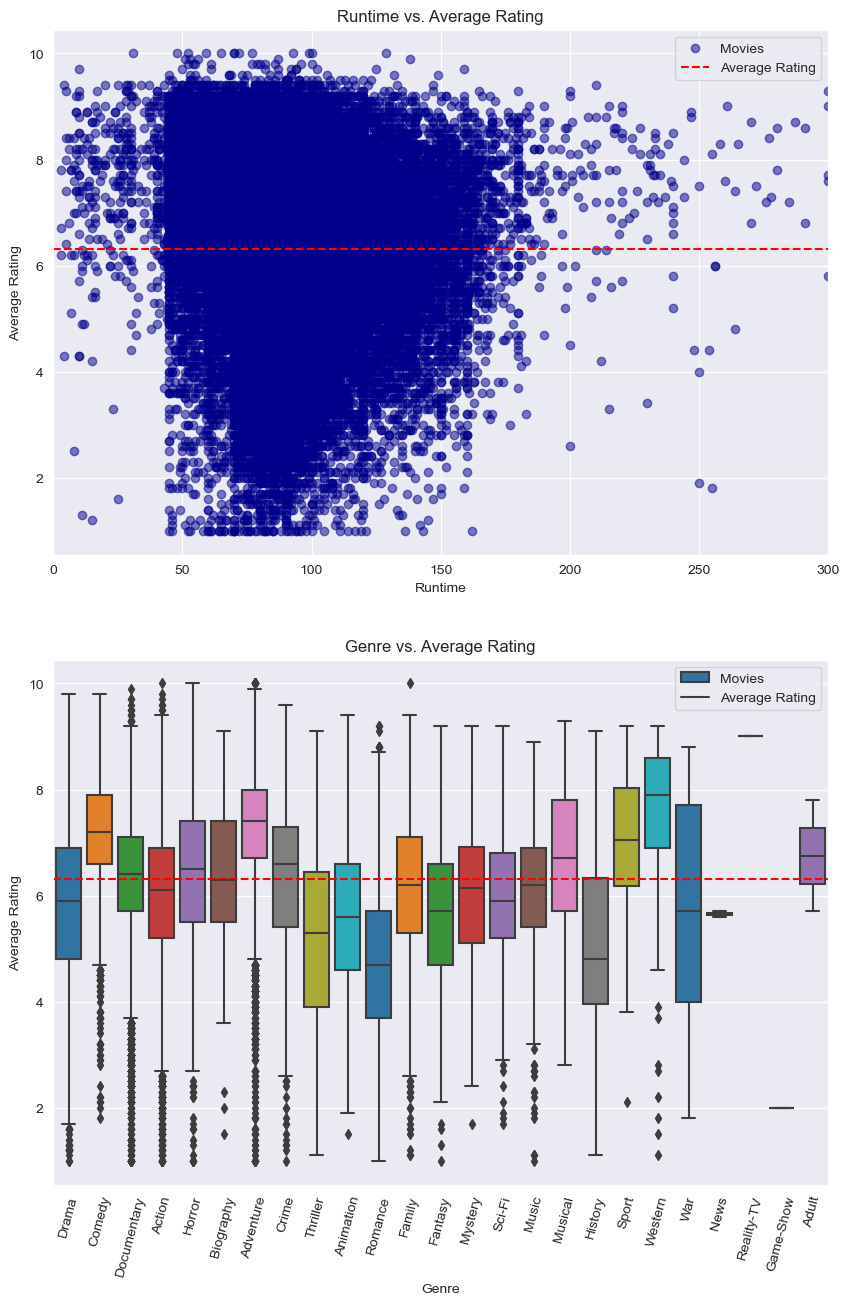

In [ ]:
#scatter plot showing the relationship between runtime and average rating
# Create a scatter plot of runtime vs. average rating
fig, axes = plt.subplots(2,1,figsize=(10, 15))

axes[0].scatter(movie_data['runtime_minutes'], movie_data['averagerating'], 
                     color='darkblue', alpha=0.5)
sns.boxplot(x='genre1', y='averagerating', data=movie_data, palette='tab10',ax=axes[1])


#add a horizontal line to show the average rating
axes[0].axhline(movie_data['averagerating'].mean(), color='red', linestyle='--')
axes[1].axhline(movie_data['averagerating'].mean(), color='red', linestyle='--')

# Add labels and title
axes[0].set_title('Runtime vs. Average Rating')
axes[0].set_xlabel('Runtime')
axes[0].set_ylabel('Average Rating')
axes[0].set_xlim(0,300)  # Limit the x-axis to remove outliers
axes[0].legend(['Movies' , 'Average Rating'])

axes[1].set_title('Genre vs. Average Rating')
axes[1].set_xlabel('Genre')
axes[1].set_xticklabels(movie_data['genre1'].value_counts().index, rotation=75)
axes[1].set_ylabel('Average Rating')
axes[1].legend(['Movies' , 'Average Rating'])

plt.show();

---
### Conclusions
---
This analysis has yielded the following conclusions:

- 

